In [1]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import random
import base64
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../src')
from utils import *

import albumentations as A
from sklearn.model_selection import train_test_split

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, ResNet50

from functools import partial
K.clear_session()

dir_data = '../data/'
model_dir = '../model'

img_size = (512, 512)
patience_early = 3
factor_reduce_lr = 0.1
patience_lr = 2
batch_size = 32
epoch = 25

2022-08-05 16:40:06.153986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ml_ai_pc/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-08-05 16:40:06.154017: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# CNN approach for grid detection

In [3]:
data, mask = process_data(dir_data, img_size)

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 38.74it/s]


In [4]:
X, X_test, y, y_test = train_test_split(data, mask, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

In [5]:
# Declare an augmentation pipeline
transform = A.Compose([A.Flip(p=0.5),
                       A.ShiftScaleRotate(shift_limit=0.1,
                                          scale_limit=0,
                                          rotate_limit=10,
                                          interpolation=1,
                                          border_mode=0,
                                          value=(0,0,0),
                                          mask_value=0,
                                          shift_limit_x=None,
                                          shift_limit_y=None,
                                          always_apply=False,
                                          p=0.5),
                       A.ChannelShuffle(p=0.5),])

# Data augmentation
k = 3
n = X.shape[0]
X_aug = np.empty((k*n, *img_size, 3)).astype(int)
y_aug = np.empty((k*n, *img_size, 1)).astype(int)

for seed in range(k):
    random.seed(seed)
    for idx, (image, mask) in enumerate(tqdm(list(zip(X_train, y_train)))):
        transformed = transform(image=image.astype(np.uint8),
                                mask=mask.astype(np.uint8))
        X_aug[(seed*n)+idx,:,:,:] = transformed["image"]
        y_aug[(seed*n)+idx,:,:,:] = transformed["mask"]

X_train = np.vstack((X_train, X_aug)).astype(int)
y_train = np.vstack((y_train, y_aug)).astype(np.float32)

X_val, y_val = X_val.astype(int), y_val.astype(np.float32)
X_test, y_test = X_test.astype(int), y_test.astype(np.float32)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape,X_test.shape, y_test.shape,)

100%|██████████████████████████████████████████| 63/63 [00:00<00:00, 366.37it/s]


(318, 512, 512, 3) (318, 512, 512, 1) (22, 512, 512, 3) (22, 512, 512, 1) (10, 512, 512, 3) (10, 512, 512, 1)


In [6]:
data, mask = None, None
X, y = None, None
X_aug, y_aug = None, None

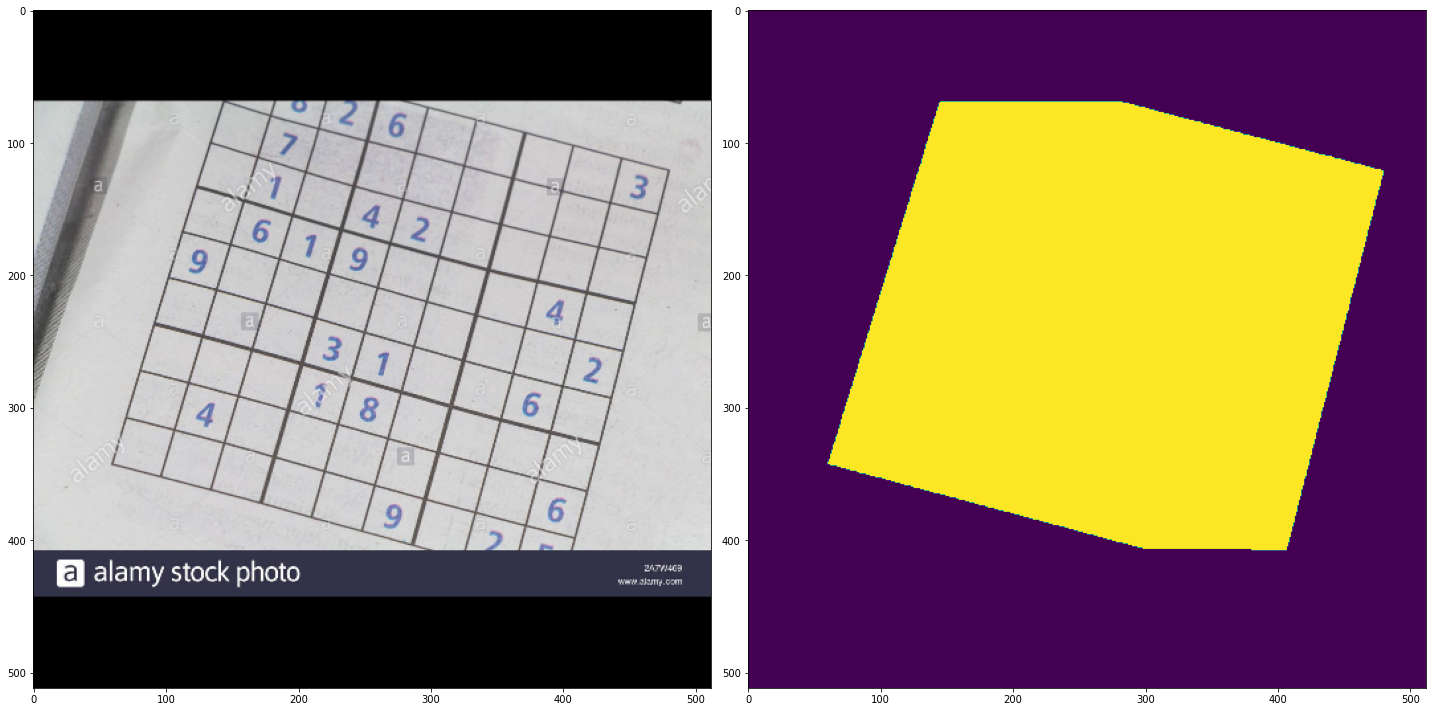

In [7]:
idx = 0
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(X_train[idx])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(y_train[idx]))

plt.tight_layout()
plt.show()

# Model architecture

In [8]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input((*input_shape, 3))

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [9]:
model = build_resnet50_unet(img_size)
model.compile(optimizer="adam",
              loss=dice_coef_loss,
              metrics=[iou, dice_coef, tversky])

2022-08-05 16:40:14.133032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 16:40:14.133823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 16:40:14.134720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ml_ai_pc/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-08-05 16:40:14.134802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PAT

# Training

In [10]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=patience_early)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=factor_reduce_lr, patience=patience_lr)
# model_path = os.path.join(model_dir,'seg_unet-epoch_{epoch:02d}-val_loss{val_loss:.4f}.h5')
# checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
callbacks_list = [early_stop, reduce_lr]

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose="auto",
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
open(os.path.join(model_dir,'grid_detection.tflite'), 'wb').write(converter.convert())

Epoch 1/25
10/10 [==============================] - 888s 89s/step - loss: 0.3653 - iou: 0.4698 - dice_coef: 0.6352 - tversky: 0.7254 - val_loss: 0.3821 - val_iou: 0.4471 - val_dice_coef: 0.6179 - val_tversky: 0.7294 - lr: 0.0010
Epoch 2/25
10/10 [==============================] - 882s 88s/step - loss: 0.2267 - iou: 0.6327 - dice_coef: 0.7734 - tversky: 0.8452 - val_loss: 0.3573 - val_iou: 0.4736 - val_dice_coef: 0.6427 - val_tversky: 0.7439 - lr: 0.0010
Epoch 3/25
10/10 [==============================] - 882s 88s/step - loss: 0.1187 - iou: 0.7886 - dice_coef: 0.8815 - tversky: 0.9190 - val_loss: 0.4496 - val_iou: 0.3797 - val_dice_coef: 0.5504 - val_tversky: 0.6710 - lr: 0.0010
Epoch 4/25
10/10 [==============================] - 882s 88s/step - loss: 0.0925 - iou: 0.8318 - dice_coef: 0.9078 - tversky: 0.9356 - val_loss: 0.3317 - val_iou: 0.5019 - val_dice_coef: 0.6683 - val_tversky: 0.7118 - lr: 0.0010
Epoch 5/25
10/10 [==============================] - 882s 88s/step - loss: 0.0682 - i

# Training metrics

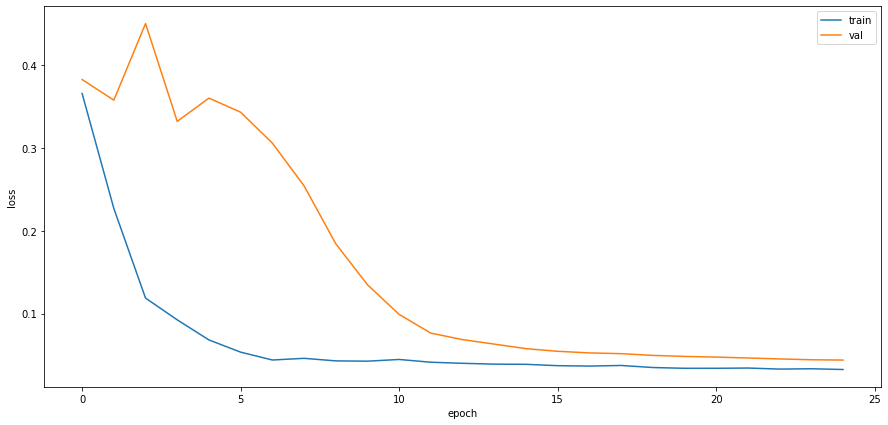

In [11]:
fig = plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Evaluation

In [38]:
def tversky_mask(a, b, alpha = 0.7, beta = 0.7):
    tp = len(np.where(a + b == 2)[0])
    tn = len(np.where(a + b == 0)[0])
    fn = len(np.where(a - b == -1)[0])
    fp = len(np.where(a - b  == 1)[0])
    
    tversky = tp / (tp + alpha * fn + beta * fp)
    return tversky

def iou_mask(a, b):
    a_area = np.count_nonzero(a == 1)
    b_area = np.count_nonzero(b == 1)
    intersection = np.count_nonzero(np.logical_and(a, b))
    iou = intersection/(a_area + b_area - intersection)
    return iou

def dice_mask(a, b):
    a_area = np.count_nonzero(a == 1)
    b_area = np.count_nonzero(b == 1)
    intersection = np.count_nonzero(np.logical_and(a, b))
    dice = 2.0 * intersection / (a_area + b_area)
    return dice

def evaluate(gt, pred):
    iou = iou_mask(pred, gt)
    dice = dice_mask(pred, gt)
    tversky = tversky_mask(pred, gt)
    return iou, dice, tversky

In [39]:
preds = np.rint(model.predict(X_test))
iou_test, dice_test, tversky_test = evaluate(y_test, preds)
print(f'IoU {iou_test:.4f} - Dice {dice_test:.4f} - Tversky {tversky_test:.4f}')

IoU 0.9785 - Dice 0.9891 - Tversky 0.9849


# Infererence on test data

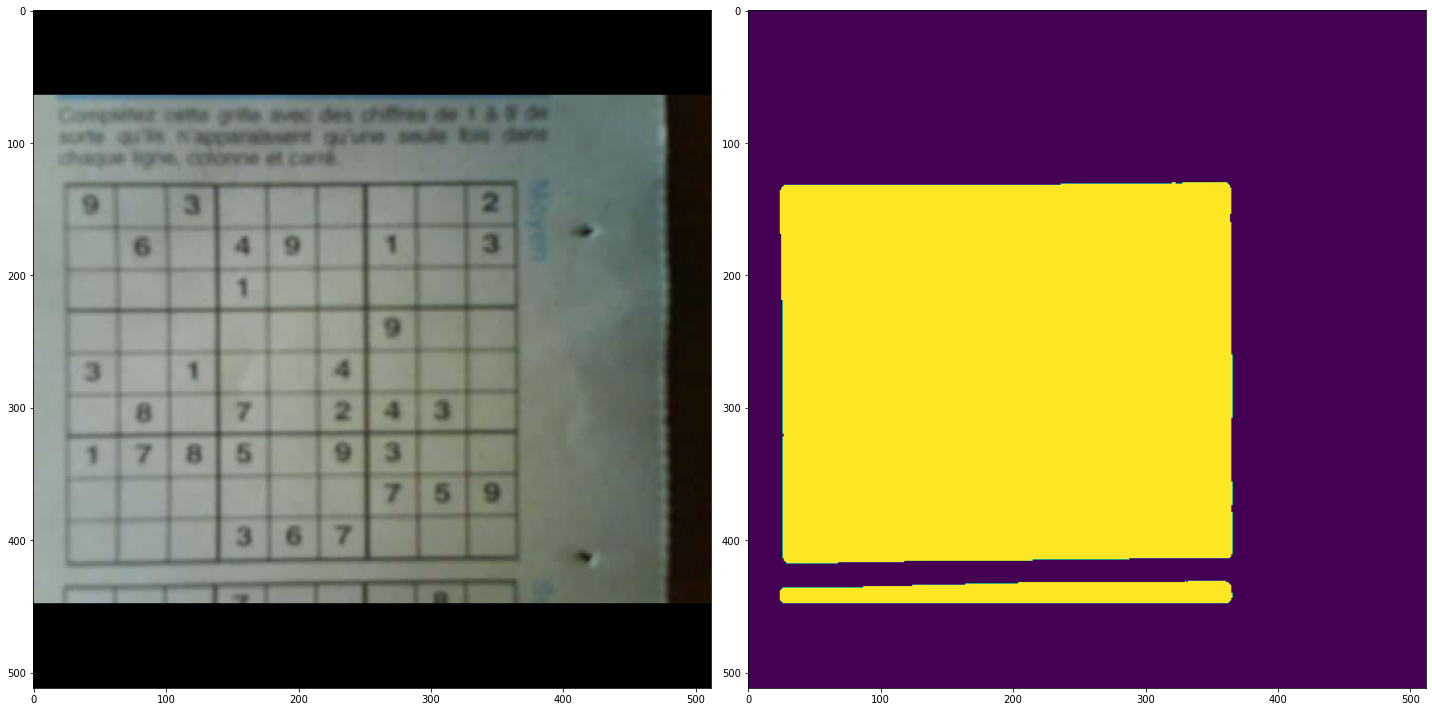

In [49]:
idx = 6
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(X_test[idx])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds[idx]))
plt.tight_layout()
plt.show()